In [1]:
import pymc3 as pm
import numpy as np
from scipy import stats
import arviz as az
import matplotlib.pyplot as plt

/home/bart/.pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(123)
trials = 10000
θ_real = 0.35
data = stats.bernoulli.rvs(p=θ_real, size=trials)
print("1s: {}".format(sum(data)))
print("0s: {}".format(len(data) - sum(data)))

1s: 3489
0s: 6511


In [3]:
with pm.Model() as model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1264.04draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f726c3da0>,
      dtype=object)

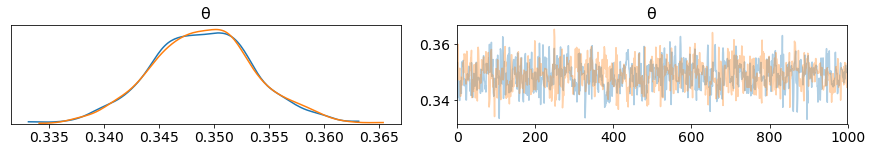

In [4]:
az.plot_trace(trace)

In [5]:
az.summary(trace)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
θ,0.35,0.0,0.0,0.34,0.36,840.0,1.0


* **HPD** The HPD is the shortest interval containing (in this case) 94% of the density of the posterior.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efbf53209e8>],
      dtype=object)

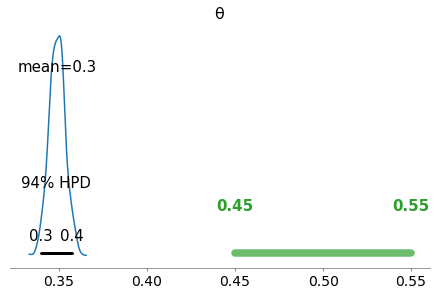

In [52]:
az.plot_posterior(trace, rope=[0.45, 0.55])

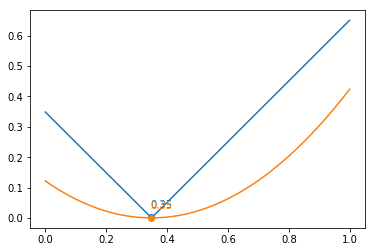

In [53]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip ([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]), (grid[mini], lossf[mini] + 0.03), color=c)

*OK, so if we want to be formal and we want to compute a single point-estimate, we must
decide which loss function we want, or in reverse, if we choose a given point-estimate, we
are implicitly (and maybe even unconsciously) deciding on a loss function.* (p.50)

*It also important to notice that, as the posterior is in the form of numerical samples, we can compute complex loss functions that don't need to be restricted by mathematical convenience or mere simplicity.* (p.50)

## Chemical shifts

([<matplotlib.axis.YTick at 0x7f7f725a1518>],
 <a list of 1 Text yticklabel objects>)

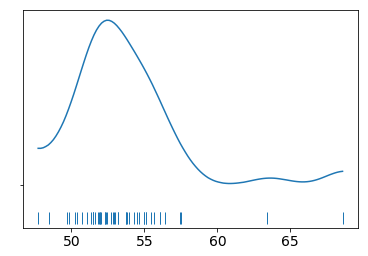

In [6]:
data = np.loadtxt("../data/chemical_shifts.csv")
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1774.47draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f73d90b70>,
      dtype=object)

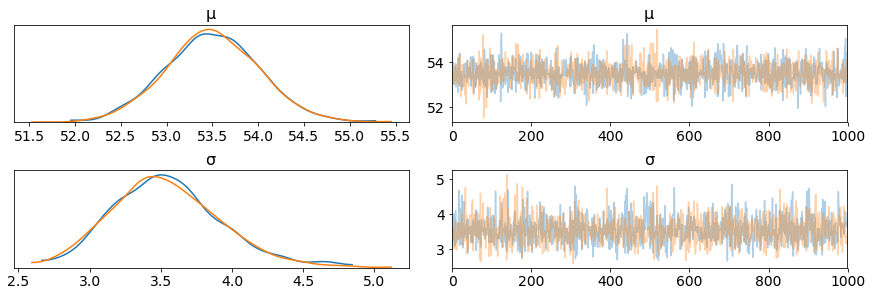

In [7]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)
az.plot_trace(trace_g)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7f706c65c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7f7063c320>)

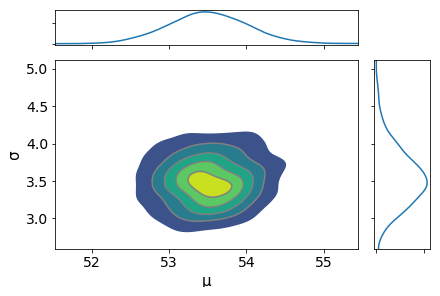

In [8]:
az.plot_joint(trace_g, kind='kde', fill_last=False)

In [9]:
az.summary(trace_g)

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
μ,53.49,0.50,0.00,52.5,54.39,2081.0,1.0
σ,3.54,0.38,0.01,2.8,4.22,1823.0,1.0


In [10]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

100%|██████████| 100/100 [00:00<00:00, 131.01it/s]


In [12]:
y_pred_g['y'].shape

(100, 48)

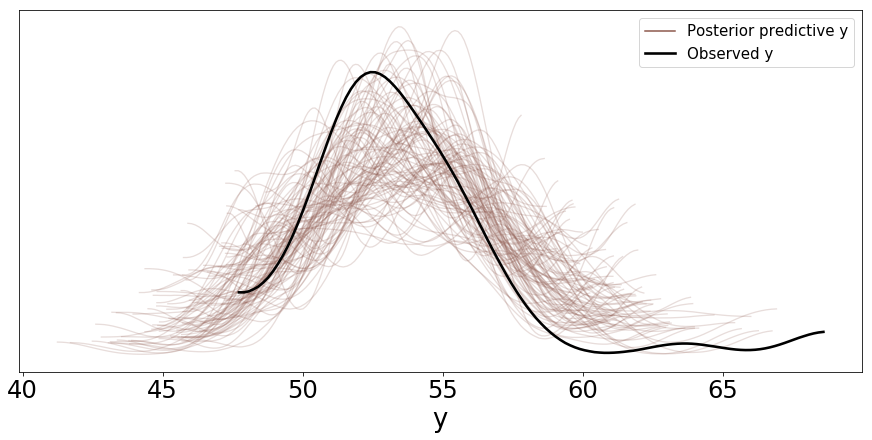

In [13]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)

In [32]:
np.mean(stats.t(loc=0, scale=1, df=10).rvs(1000000))

-0.0014543207248522154

*So, as a rule of thumb, for values of not too small, and taking into account that it is not theoretically fully correct, we can consider the scale of a Student's t-distribution as a reasonable practical proxy for the standard deviation of the data after removing outliers.* (p.64)